## Warehouse test

In [1]:
import os
import numpy as np
from environment import Environment
from groq import Groq
import copy
import configs
import pickle
import re

client = Groq(api_key="")

In [2]:
with open('./test_set/{}_{}agents.pth'.format('warehouse', 4), 'rb') as f:
    tests = pickle.load(f)

In [3]:
# negotiator를 구성하기 위한 union find 알고리즘
def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

def find_direction(sentence):
    # 모든 단어를 찾기 위한 정규 표현식 패턴
    words = re.findall(r'"([^"]*)"|\b\w+\b', sentence)
    directions = ["north", "west", "south", "east"]
    # 모든 단어를 뒤에서부터 확인
    for word in reversed(words):
        if word.lower() in directions:
            return word
    return 'none'

# 방향 정의
directiondict = {
    'stay': 0, 'north': 1, 'south': 2, 'west': 3, 'east': 4
}

In [4]:
# 프롬프트
class gpt4pathfinding:
    def navigate(self, x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV):
        response = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": "당신은 방향 감각이 뛰어난 탐험가입니다. 당신은 목표물에 도달하기 위해서 어떤 경로를 탐색하야 할지 잘 압니다."},
            {"role": "user", "content":
                f"""
                당신의 현재 좌표는 ({x},{y}) 이며 당신의 목표 지점은 ({x_finish},{y_finish}) 입니다.
                서쪽은 -x축에 대응합니다
                동쪽은 +x축에 대응합니다
                남쪽은 -y축에 대응합니다
                북쪽은 +y축에 대응합니다
                당신은 동쪽, 서쪽, 남쪽, 북쪽, 그리고 가만히 있기 5가지의 선택지가 있습니다.
                따라서, 당신의 답은 {{east}}, {{west}}, {{south}}, {{north}}, {{stay}} 중 하나가 됩니다.
                당신은 한 번에 한 번만 움직일 수 있습니다.
                당신은 가로로 긴 창고 환경에 있기 때문에, y축으로 이동이 가능할 때는 y축을 먼저 이용하는 것이 좋습니다.
                {east}
                {west}
                {south}
                {north}
                아래는 당신이 최근 방문한 좌표의 목록입니다.
                {coordinates}
                위 좌표의 목록을 보고, 당신이 같은 좌표를 반복하고 있는지를 yes와 no로 결정하세요.
                만약 yes라면, 현재의 목표물을 무시하고, 반복되는 좌표를 지정하세요.
                당신은 그 좌표로부터 멀리 벗어나는 데에 집중합니다.
                만약 no라면, 당신은 목표물에 다시 집중합니다.
            
                당신은 다음 어느 좌표로 움직이겠습니까?

                Think step by step and answer with json format {{"move": "direction"}}
                """
            }],
        )
        return response.choices[0].message.content
    
    def give_way(self, east, west, north, south, direction):
        response = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": "You are a veteran adventurer with a great sense of direction. You understand which direction you need to move to get from where you are to where you want to go."},
            {"role": "user", "content":
                f"""
                You MUST avoid collisions with prior path finder.
                You can only move east, west, south and north or stay.
                So, your answer will be {{east}}, {{west}}, {{south}}, {{north}}, or {{stay}}.
                You can only make one move at a time.
                {east}
                {west}
                {south}
                {north}
                To the {direction} of you is prior path finder.
                Which direction do you move next?
                I highly recommend going to the 90-degree turn rather than the other side of the pathfinder, but you can ignore this instruction depending on your situation.
                
                Think step by step and answer with json format {{"move": "direction"}}
                """
            }],
        )
        return response.choices[0].message.content
    
pathfinder = gpt4pathfinding()

In [5]:
def run_one_example(example, max_steps):

  num_agents = len(example[1])
  map_width = len(example[0]) - 1

  env = Environment()
  env.load(np.array(example[0]), np.array(example[1]), np.array(example[2]))
  
  #에이전트들의 지난번 액션들과 좌표
  action_list = [[] for _ in range(num_agents)]
  coordinate_list = [[] for _ in range(num_agents)]
  step_list = [0 for _ in range(num_agents)]

  max_steps = max_steps
  steps = 0

  # turn
  while steps < max_steps:

    for i in range(num_agents):
      if not np.array_equal(env.agents_pos[i], env.goals_pos[i]):
          step_list[i] += 1

    for i in range(num_agents):
      x_coordinate = env.observe()[1][i][1]
      y_coordinate = map_width-env.observe()[1][i][0]

      if len(coordinate_list[i]) >= 5:
        coordinate_list[i].pop(0)

      coordinate_list[i].append([x_coordinate, y_coordinate])

    step = [0 for i in range(num_agents)]

    #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
    FOV_agents = []
    for i in range(num_agents):
      if np.any(env.observe()[0][i][0][2:7, 2:7]):
        non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
        non_zero_elements = [element - 1 for element in non_zero_elements]
        non_zero_elements.append(i)
        FOV_agents.append(non_zero_elements)

    #알고리즘을 이용해 연결된 집합 찾기
    connected_sets = merge_sets(FOV_agents)

    #연결이 있는 모든 에이전트들
    deadlocked_agents = [item for sublist in connected_sets for item in sublist]

    for i in range(num_agents):

      #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
      if i not in deadlocked_agents:
        
        a_obs = env.observe()[0][i][1]
        x = env.observe()[1][i][1]
        y = map_width-env.observe()[1][i][0]
        x_finish = example[2][i][1]
        y_finish = map_width-example[2][i][0]

        if a_obs[4][3] == 0:
          west = """To your west lies a path."""
        else:
          west = """Your west is blocked by a wall."""

        if a_obs[4][5] == 0:
          east = """To your east lies a path."""
        else:
          east = """Your east is blocked by a wall."""

        if a_obs[5][4] == 0:
          south = """To your south lies a path."""
        else:
          south = """Your south is blocked by a wall."""

        if a_obs[3][4] == 0:
          north = """To your north lies a path."""
        else:
          north = """Your north is blocked by a wall."""

        if len(action_list[i]) == 0:
          last_action = """"""
        elif action_list[i][-1] in ['West', 'West.']:
          last_action = f"""You came from east."""
        elif action_list[i][-1] in ['East', 'East.']:
          last_action = f"""You came from west."""
        elif action_list[i][-1] in ['South', 'South.']:
          last_action = f"""You came from north."""
        elif action_list[i][-1] in ['North', 'North.']:
          last_action = f"""You came from south."""
        elif action_list[i][-1] in ['Stay', 'Stay.']:
          last_action = f"""You paused once for another agent or you reached your goal."""
        else:
          last_action = """"""

        coordinates = f"""{coordinate_list[i]}"""

        agent_FOV = '\n'.join(' '.join(map(str, row)) for row in env.observe()[0][i][1][2:7, 2:7])

        result = pathfinder.navigate(x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV)

        result = find_direction(result)

        if result not in directiondict:
          result = 'stay'

        action_list[i].append(result)

        step[i] = directiondict[result]
      
    
    # 교착상태에 빠진 에이전트에 대해
    for connected_set in connected_sets:
      
      results = []

      for i in connected_set: # 여기서 i는 agent의 번호들
      
      #각각의 에이전트에 대해 원래 계획된 경로를 계산

        a_obs = env.observe()[0][i][1]
        x = env.observe()[1][i][1]
        y = map_width-env.observe()[1][i][0]
        x_finish = example[2][i][1]
        y_finish = map_width-example[2][i][0]

        if a_obs[4][3] == 0:
          west = """To your west lies a path."""
        else:
          west = """Your west is blocked by a wall."""

        if a_obs[4][5] == 0:
          east = """To your east lies a path."""
        else:
          east = """Your east is blocked by a wall."""

        if a_obs[5][4] == 0:
          south = """To your south lies a path."""
        else:
          south = """Your south is blocked by a wall."""

        if a_obs[3][4] == 0:
          north = """To your north lies a path."""
        else:
          north = """Your north is blocked by a wall."""

        if len(action_list[i]) == 0:
          last_action = """"""
        elif action_list[i][-1] in ['West', 'West.']:
          last_action = f"""You came from east."""
        elif action_list[i][-1] in ['East', 'East.']:
          last_action = f"""You came from west."""
        elif action_list[i][-1] in ['South', 'South.']:
          last_action = f"""You came from north."""
        elif action_list[i][-1] in ['North', 'North.']:
          last_action = f"""You came from south."""
        elif action_list[i][-1] in ['Stay', 'Stay.']:
          last_action = f"""You paused once for another agent or you reached your goal."""
        else:
          last_action = """"""

        coordinates = f"""{coordinate_list[i]}"""

        agent_FOV = '\n'.join(' '.join(map(str, row)) for row in env.observe()[0][i][1][2:7, 2:7])

        result = pathfinder.navigate(x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV)

        result = find_direction(result)

        if result not in directiondict:
          result = 'stay'

        results.append(result)

      env_copy = copy.deepcopy(env)
      planned_step = [0 for _ in range(num_agents)]
      for idx, agent_idx in enumerate(connected_set):
        planned_step[agent_idx] = directiondict[results[idx]]
      if -0.5 in env_copy.step(planned_step)[1]:
        collision = True
      else:
        collision = False

      if not collision:
        for idx, agent_idx in enumerate(connected_set):
          action_list[agent_idx].append(results[idx])
          step[agent_idx] = directiondict[results[idx]]
      # 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
      # 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
      else:
      # 먼저 prior agent는 원래대로 이동하게 함
        prior_agent_number = max(connected_set)
        prior_agent_idx = connected_set.index(prior_agent_number)
        action_list[prior_agent_number].append(results[prior_agent_idx])
        step[prior_agent_number] = directiondict[results[prior_agent_idx]]
        for i in connected_set:
          if i != prior_agent_number:
              a_obs = env.observe()[0][i][1]
              x = env.observe()[1][i][1]
              y = map_width-env.observe()[1][i][0]
              x_finish = example[2][i][1]
              y_finish = map_width-example[2][i][0]

              if a_obs[4][3] == 0:
                  west = """To your west lies a path."""
              else:
                  west = """Your west is blocked by a wall."""

              if a_obs[4][5] == 0:
                  east = """To your east lies a path."""
              else:
                  east = """Your east is blocked by a wall."""

              if a_obs[5][4] == 0:
                  south = """To your south lies a path."""
              else:
                  south = """Your south is blocked by a wall."""

              if a_obs[3][4] == 0:
                  north = """To your north lies a path."""
              else:
                  north = """Your north is blocked by a wall."""

              # prior agent의 direction 구하기
              agent_map = env.observe()[0][i][0][2:7, 2:7]
              center = (2, 2)
              max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

              row_diff = center[0] - max_position[0]
              col_diff = center[1] - max_position[1]

              if row_diff > 0 and col_diff > 0:
                  direction = "northwest"
              elif row_diff > 0 and col_diff == 0:
                  direction = "north"
              elif row_diff > 0 and col_diff < 0:
                  direction = "northeast"
              elif row_diff == 0 and col_diff > 0:
                  direction = "west"
              elif row_diff == 0 and col_diff < 0:
                  direction = "east"
              elif row_diff < 0 and col_diff > 0:
                  direction = "southwest"
              elif row_diff < 0 and col_diff == 0:
                  direction = "south"
              elif row_diff < 0 and col_diff < 0:
                  direction = "southeast"
              else:
                  direction = "center"

              result = pathfinder.give_way(east, west, north, south, direction)

              result = find_direction(result)

              if result not in directiondict:
                result = 'stay'

              action_list[i] = []
      
              step[i] = directiondict[result]

    observation, rewards, done, info = env.step(step)

    env.render()

    if done:
      break
    steps += 1

  return step_list

In [6]:
def simulate_all_tests(tests, max_steps):
    all_step_lists = []
    for example in tests:
        step_list = run_one_example(example, max_steps)
        all_step_lists.append(step_list)
    return all_step_lists

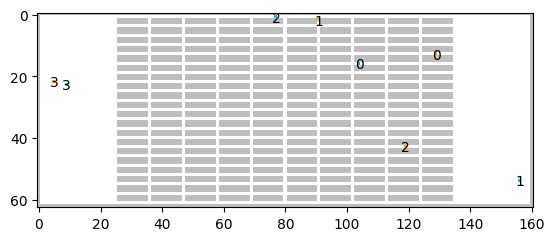

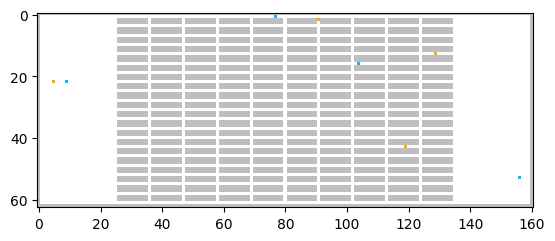

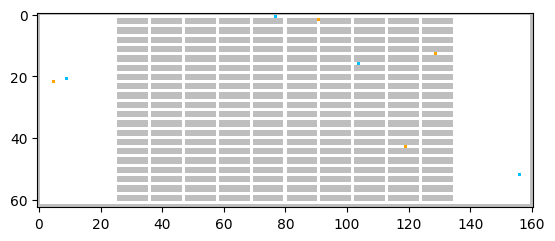

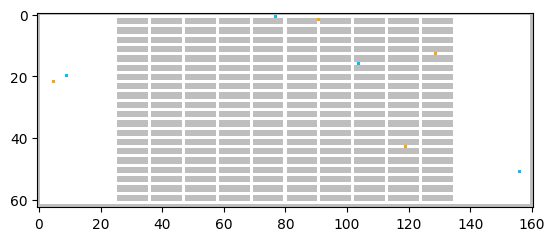

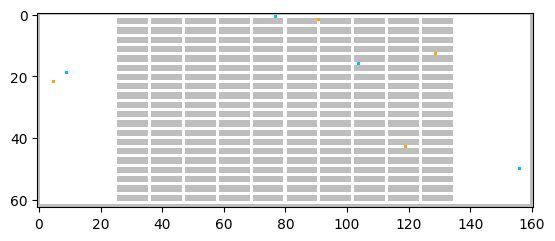

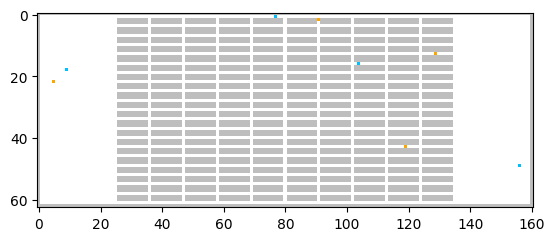

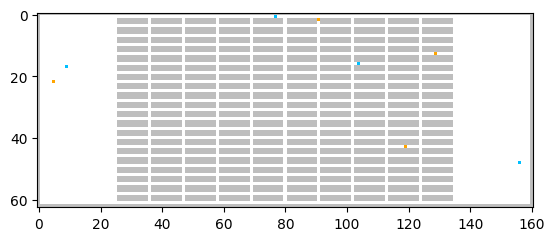

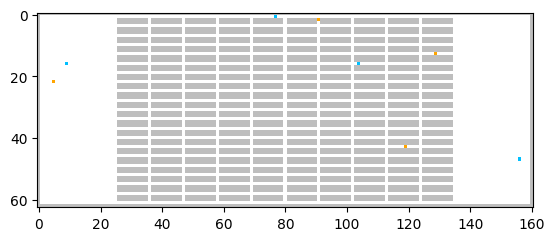

: 

In [7]:
all_step_lists = simulate_all_tests(tests[:1], 100)